In [1]:
#All the version from the libraries used are described in the ReadMe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
import random

Data loading, cleaning, pre-processing for the dataset 1:

In [3]:
#Loading the 1 dataset from D. Olszewski, et al.
#Part of the filtering from the 2.1.2 section was performed in Excel. The "Reproduced" column was filtered to only "0" and "1" values.

df = pd.read_csv("Dataset 1.csv")

#Removing non essential columns according to the the 2.1.2 section
drop_cols = ["Unnamed: 0", "Paper Title", "Author", "Affiliation", "Link to Paper", "Code", "Conference", "RepoGoal", "Reason", "Year", "Output", 
             "ModelUsed", "Out-of-box"]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [4]:
#Data transformations. The data transformations were performed according to the the 2.1.2 section

#Experiment Availability
def encode_experiment_availability(x):
    if x in [-1, 2, 8]:
        return 0
    else:
        return 1
if "Available" in df.columns:
    df["Available"] = df["Available"].apply(encode_experiment_availability)

#ReadMe
def encode_readme(x):
    if pd.isna(x) or x in [-1,0]:
        return 0
    else:
        return 1
if "ReadMe" in df.columns:
    df["ReadMe"] = df["ReadMe"].apply(encode_readme)

#Trained Model
if "TrainedModel" in df.columns:
    df["TrainedModel"] = df["TrainedModel"].apply(lambda x: 0 if x != 1 else 1)

#Runs (target)
df["Runs"] = df["Runs"].astype(int)

# Data Available
def encode_data_availability(x):
    if x in [-1,0,8]:
        return 0
    else:
        return 1
if "Data_Available" in df.columns:
    df["Data_Available"] = df["Data_Available"].apply(encode_data_availability)

#Train/test
if "Train/test" in df.columns:
    df["Train/test"] = df["Train/test"].apply(lambda x: 0 if x != 1 else 1)

#Hyperparameters
if "Hyperparameters" in df.columns:
    df["Hyperparameters"] = df["Hyperparameters"].replace(-1,0)
    df["Hyperparameters"] = df["Hyperparameters"].apply(lambda x: 0 if x==0 else 1)

#Training Described
if "Training Described" in df.columns:
    df["Training Described"] = df["Training Described"].replace(-1,0)
    df["Training Described"] = df["Training Described"].apply(lambda x: 0 if x==0 else 1)

#Renaming the columns for that the visuals and tables to look proper
df = df.rename(columns={
    'Available': 'Experiment availability',
    'TrainedModel': 'Trained model inclusion',
    'Data_Available': 'Data availability',
    'Train/test': 'Train/test split',
    'Hyperparameters': 'Hyperparameter specification',
    'ReadMe': 'Inclusion of a ReadMe',
    'Training Described': 'Training description',
    'Runs': 'Reproduced'
})

#Labeled "Reproduced" as a variable for easier computation in next parts
target = "Reproduced"

#Checking on the transformation results
print(df.head())

   Experiment availability  Inclusion of a ReadMe  Trained model inclusion  \
0                        1                      1                        0   
1                        1                      1                        0   
2                        1                      0                        0   
3                        1                      1                        0   
4                        1                      1                        0   

   Reproduced  Data availability  Train/test split  \
0           0                  1                 1   
1           0                  0                 0   
2           1                  1                 0   
3           1                  0                 1   
4           0                  0                 0   

   Hyperparameter specification  Training description  
0                             1                     1  
1                             1                     1  
2                             1       

Exploratory data analysis for the dataset 1:

In [6]:
#Column statistics table computation

#Add all the columns to a python list of column names 
feature_cols = df.columns.tolist()

#For each column in the list calculate count for values and mean
for col in feature_cols:
    counts = df[col].value_counts()
    mean = df[col].mean()
    print(f"\nColumn: {col}")
    print(f"Counts:\n{counts}")
    print(f"Mean's: {mean:.2f}")

#For each column in the list calculate missing values
for col in feature_cols:
    missing = df[col].isna().sum()
    print("\n")
    print(f"{col}: {missing} missing values")

#Summary table with describe()
summary = df[feature_cols].describe().T
print("\nSummary table:")
print(summary)


Column: Experiment availability
Counts:
Experiment availability
1    212
0      3
Name: count, dtype: int64
Mean's: 0.99

Column: Inclusion of a ReadMe
Counts:
Inclusion of a ReadMe
1    184
0     31
Name: count, dtype: int64
Mean's: 0.86

Column: Trained model inclusion
Counts:
Trained model inclusion
0    155
1     60
Name: count, dtype: int64
Mean's: 0.28

Column: Reproduced
Counts:
Reproduced
0    156
1     59
Name: count, dtype: int64
Mean's: 0.27

Column: Data availability
Counts:
Data availability
1    174
0     41
Name: count, dtype: int64
Mean's: 0.81

Column: Train/test split
Counts:
Train/test split
0    108
1    107
Name: count, dtype: int64
Mean's: 0.50

Column: Hyperparameter specification
Counts:
Hyperparameter specification
1    163
0     52
Name: count, dtype: int64
Mean's: 0.76

Column: Training description
Counts:
Training description
1    179
0     36
Name: count, dtype: int64
Mean's: 0.83


Experiment availability: 0 missing values


Inclusion of a ReadMe: 0 missi

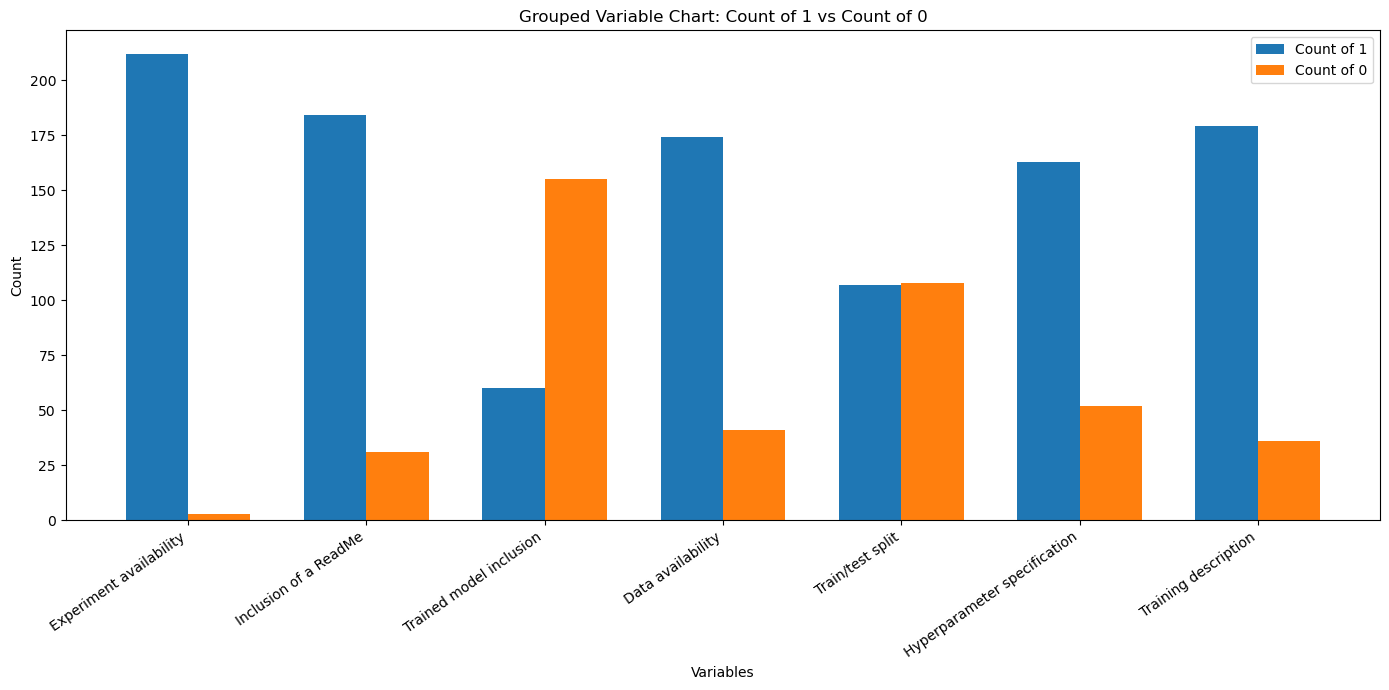

In [7]:
#The counts of 1 and 0 values grouped by variable visual computation 

#Target column is excluded and only independent variables are left
feature_cols = [col for col in df.columns if col != target]

#Lists to store count of 1 and 0
count_1 = []
count_0 = []

#Loop through all variables
for col in feature_cols:
    count_1.append((df[col] == 1).sum()) #Sum for column variable
    count_0.append((df[col] == 0).sum())

#Convert the lists to numpy arrays for easier numerical operations
count_1 = np.array(count_1)
count_0 = np.array(count_0)

#Visual formatting
x = np.arange(len(feature_cols))
width = 0.35
plt.figure(figsize=(14, 7))
plt.bar(x - width/2, count_1, width, label="Count of 1")
plt.bar(x + width/2, count_0, width, label="Count of 0")
plt.xlabel("Variables")
plt.ylabel("Count")
plt.title("Grouped Variable Chart: Count of 1 vs Count of 0")
plt.xticks(x, feature_cols, rotation=35, ha="right")
plt.legend()
plt.tight_layout()

#Display visual
plt.show()

In [8]:
#VIF calculation for the 1 dataset

X = df[feature_cols] #Independent variables
X_const = sm.add_constant(X) #A constant is needed for computation according to the statsmodels documentation

vif_data = pd.DataFrame() #Dataframe to store VIF results
vif_data["Variable"] = X_const.columns #Store column names
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])] #Regressing each variable against all others to get VIF

print(vif_data)

                       Variable        VIF
0                         const  85.297155
1       Experiment availability   1.059178
2         Inclusion of a ReadMe   1.059383
3       Trained model inclusion   1.031861
4             Data availability   1.261854
5              Train/test split   1.321672
6  Hyperparameter specification   1.279643
7          Training description   1.225853


Hypothesis testing for the dataset 1:

In [10]:
#Hypothesis testing with chi-square test of independence 

results = [] #Store results for each variable

#Loop through the variables and calculate the contingency table and chi-square test of independence
for col in feature_cols:
    table = pd.crosstab(df[col], df["Reproduced"])
    chi2, p, dof, expected = chi2_contingency(table)
    results.append({"Feature": col, "Chi2": chi2, "p-value": p})

#Convert results into a dataframe and sort by p-value
chi_df = pd.DataFrame(results).sort_values("p-value")
print(chi_df)

                        Feature      Chi2   p-value
2       Trained model inclusion  7.495749  0.006184
3             Data availability  5.006301  0.025255
1         Inclusion of a ReadMe  3.039435  0.081264
5  Hyperparameter specification  0.633648  0.426020
0       Experiment availability  0.177408  0.673610
6          Training description  0.024078  0.876686
4              Train/test split  0.001759  0.966545


Logistic regression for the dataset 1:

In [12]:
#Independent variables
X = df[["Trained model inclusion", "Data availability"]] #These were selected after the elimination of non significant variables by P>|z| value
#Dependent variable
Y = df['Reproduced']

X = sm.add_constant(X) #Constant
model = sm.Logit(Y, X).fit() #Other versions were tried: (penalty='l1'/'l2', maxiter=500/maxiter=100, method='lbfgs'/method='newton-cg')
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.555592
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Reproduced   No. Observations:                  215
Model:                          Logit   Df Residuals:                      212
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Jan 2026   Pseudo R-squ.:                 0.05448
Time:                        20:57:44   Log-Likelihood:                -119.45
converged:                       True   LL-Null:                       -126.33
Covariance Type:            nonrobust   LLR p-value:                  0.001025
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.1956      0.492     -4.458      0.000      -3.161   

Classification for the dataset 1:

In [14]:
#Independent variables
X = df[feature_cols]
#Dependent varirable
Y = df["Reproduced"]
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=42, stratify=Y) #Training/test split specification

In [15]:
#Random Forest classifier parameters
clf = RandomForestClassifier(
    n_estimators=100, #100 Trees
    random_state=42,
    class_weight='balanced' #'balanced' mode for classes for the data imbalance in the dataset
)
clf.fit(X_train, Y_train) #Train model on training set
Y_pred = clf.predict(X_test) #Predict labels for test set
print("Classification Report:\n")
print(classification_report(Y_test, Y_pred, zero_division=0))

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        31
           1       0.40      0.50      0.44        12

    accuracy                           0.65        43
   macro avg       0.59      0.60      0.60        43
weighted avg       0.68      0.65      0.66        43



In [16]:
#Calculate the negative (0 class) and positive (1 class) research papers in the train set for
#the scale_pos_weight parameter in XGBoost classifier
n_pos = Y_train.sum()
n_neg = len(Y_train) - n_pos

print(n_pos)
print(n_neg)

47
125


In [17]:
#XGBoost classifier parameters
clf = xgb.XGBClassifier(
    n_estimators=100, #100 Trees
    random_state=42,
    scale_pos_weight= 125/47 #'125/47' ratio between negative and positive mode for classes for the data imbalance in the dataset
)
clf.fit(X_train, Y_train) #Train model on training set
Y_pred = clf.predict(X_test) #Predict labels for test set
print("Classification Report:\n")
print(classification_report(Y_test, Y_pred, zero_division=0))

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.77      0.79        31
           1       0.46      0.50      0.48        12

    accuracy                           0.70        43
   macro avg       0.63      0.64      0.63        43
weighted avg       0.71      0.70      0.70        43



In [18]:
#Feature importance analysis

#Get booster object from the trained model (used for accessing feature importance information)
booster = clf.get_booster()
importance_gain = booster.get_score(importance_type='gain') #Get feature importance scores based on gain

#Convert to dataframe from the importance dictionary
feature_importance_gain = (
    pd.DataFrame.from_dict(importance_gain, orient='index', columns=['Importance'])
    .rename_axis('Variable')
    .reset_index()
    .sort_values(by='Importance', ascending=False)
)
#Normalizing importance scores
feature_importance_norm = feature_importance_gain.copy() #Copy to not change the original data 
feature_importance_norm['Importance_norm'] = feature_importance_norm['Importance'] / feature_importance_norm['Importance'].sum() #Normalize feature importance by importance/importance sum
print(feature_importance_norm)

                       Variable  Importance  Importance_norm
0         Inclusion of a ReadMe    0.242224         0.279561
2             Data availability    0.233324         0.269289
1       Trained model inclusion    0.121458         0.140180
5          Training description    0.100986         0.116552
4  Hyperparameter specification    0.090106         0.103995
3              Train/test split    0.078347         0.090423


In [19]:
#Feature effect analysis

#Dataframe to store the change in predicted probabilities
feature_effects = pd.DataFrame(index=X_train.columns, columns=[f'Class_{i}' for i in sorted(Y.unique())], dtype=float)

#Loop through each variable
for feature in X_train.columns:
    X_temp = X_test.copy() #Copy to not change the original data
    X_temp[feature] = 0 #Set variable to 0 for all samples
    prob_0 = clf.predict_proba(X_temp).mean(axis=0)
    X_temp[feature] = 1 #Set variable to 1 for all samples
    prob_1 = clf.predict_proba(X_temp).mean(axis=0)
    feature_effects.loc[feature] = prob_1 - prob_0 #Effect of switching the variable from 0 to 1

#Display effects
print("\nChange in predicted class probabilities when variable is 1 vs 0:\n")
print(feature_effects.sort_values(by=feature_effects.columns[-1], ascending=False))


Change in predicted class probabilities when variable is 1 vs 0:

                               Class_0   Class_1
Inclusion of a ReadMe        -0.300746  0.300746
Trained model inclusion      -0.190395  0.190395
Data availability            -0.108196  0.108196
Experiment availability       0.000000  0.000000
Training description          0.004463 -0.004463
Train/test split              0.035207 -0.035207
Hyperparameter specification  0.059524 -0.059524


Sampling a subset of the 1 dataset for the new annotated dataset

In [21]:
#Loading the 1 dataset again with no transformations
df = pd.read_csv("Dataset 1.csv")

#Only taking necessary column from the dataset to find the research papers for annotation and the reproducibility factor from the 1 dataset
take_cols = ["Unnamed: 0", "Paper Title", "Author", "Link to Paper", "Year", "Runs"]

df = df.drop(columns=[c for c in df.columns if c not in take_cols])

In [22]:
random.seed(42) #Setting a seed for the random process

#Randomly sample 139 papers
sample_df = df.sample(n=139, random_state=42)

#Save as a csv file for the new dataset annotation
sample_df.to_csv("sampled_subset.csv", index=False)